### Import libraries

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib as ta
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns

### Setup parameters

In [37]:
start_date = '1970-01-01'
end_date = '2023-12-30'
symbol = 'TSLA'

### Load stock data from Yahoo Finance

In [38]:
df = yf.download(symbol, start_date, end_date)
print(df)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2023-12-22  256.760010  258.220001  251.369995  252.539993  252.539993   
2023-12-26  254.490005  257.970001  252.910004  256.609985  256.609985   
2023-12-27  258.350006  263.339996  257.519989  261.440002  261.440002   
2023-12-28  263.660004  265.130005  252.710007  253.179993  253.179993   
2023-12-29  255.100006  255.190002  247.429993  248.479996  248.479996   

               Volume  
Date         

In [39]:
split = int(0.7*len(df))

### Calculate technical indicators

In [40]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod=10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()

### Prepare data for machine learning

In [41]:
X = df.iloc[:, :9]
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=94 / 100, random_state=75)

### Train the model

In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### examine the cofficients

In [43]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[0.0002656317068376982]
1,High,[0.0002775095213055649]
2,Low,[0.00026217207262303863]
3,Close,[0.0002732132313724946]
4,Adj Close,[0.0002732132313724946]
5,Volume,[-5.682096852134832e-10]
6,S_10,[0.00025317784757716995]
7,Corr,[2.8058299885724256e-07]
8,RSI,[-5.2953521470026664e-05]


### Calculate class probabilities

In [44]:
start_date = '2019-12-22'
end_date = '2024-01-01'

# Create a list containing the start and end dates
prediction_date = [start_date, end_date]

# Use the list of dates for prediction
probability = model.predict_proba(X_test)
print(probability)

[[0.51434815 0.48565185]
 [0.50806255 0.49193745]
 [0.50077737 0.49922263]
 ...
 [0.42958222 0.57041778]
 [0.50913623 0.49086377]
 [0.43388863 0.56611137]]


### Evaluate model

In [45]:
probability = model.predict_proba(X_test)
predicted = model.predict(X_test)

### Plot cumulative strategy returns.

/var/folders/fn/m239lw_11_l3vhyq209j55z80000gn/T/ipykernel_63104/544206059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_Signal'] = model.predict(X)
/var/folders/fn/m239lw_11_l3vhyq209j55z80000gn/T/ipykernel_63104/544206059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSLA_returns'] = np.log(df['Close']/df['Close'].shift(1))
/var/folders/fn/m239lw_11_l3vhyq209j55z80000gn/T/ipykernel_63104/544206059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

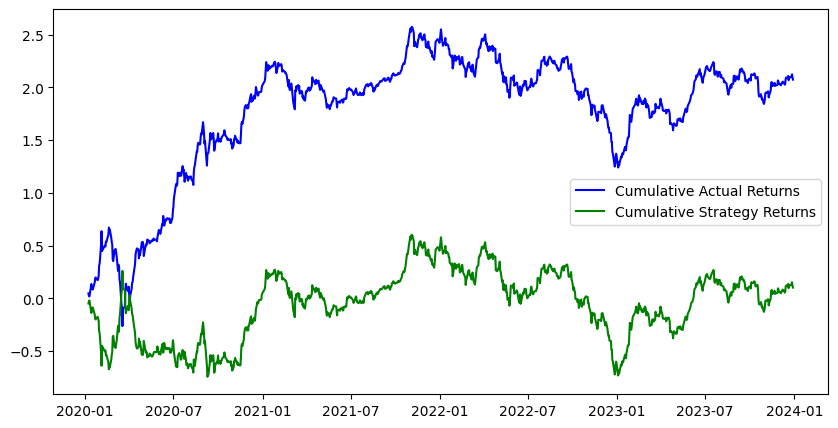

In [46]:
# Calculate Predicted Signal
df['Predicted_Signal'] = model.predict(X)

# Calculate AAPL Returns
df['TSLA_returns'] = np.log(df['Close']/df['Close'].shift(1))

# Calculate Cumulative AAPL Returns
Cumulative_TSLA_returns = np.cumsum(df[split:]['TSLA_returns'])

# Calculate Strategy Returns
df['Strategy_returns'] = df['TSLA_returns'] * df['Predicted_Signal'].shift(1)

# Calculate Cumulative Strategy Returns
Cumulative_Strategy_returns = np.cumsum(df[split:]['Strategy_returns'])

# Plotting
plt.figure(figsize=(10,5))

# Plot Cumulative AAPL Returns
plt.plot(Cumulative_TSLA_returns, color='b', label='Cumulative Actual Returns')

# Plot Cumulative Strategy Returns
plt.plot(Cumulative_Strategy_returns, color='g', label='Cumulative Strategy Returns')

plt.legend()
plt.show()

### compute confusion matrix and plot as heatmap.

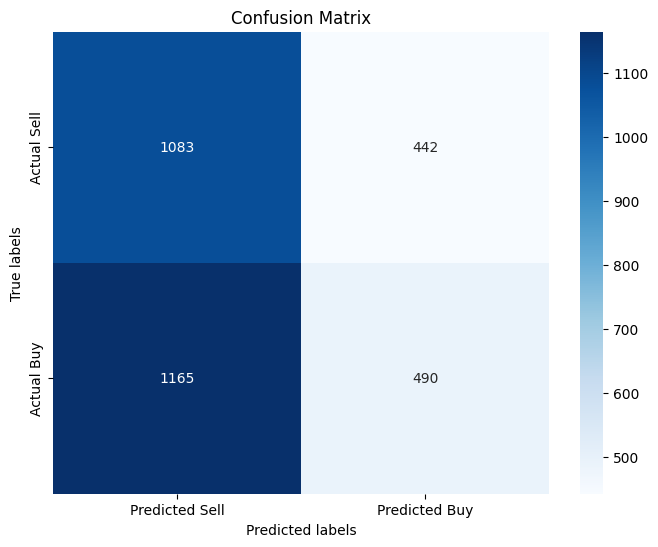

              precision    recall  f1-score   support

          -1       0.48      0.71      0.57      1525
           1       0.53      0.30      0.38      1655

    accuracy                           0.49      3180
   macro avg       0.50      0.50      0.48      3180
weighted avg       0.50      0.49      0.47      3180



In [47]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Sell', 'Predicted Buy'], yticklabels=['Actual Sell', 'Actual Buy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, predicted))

### calculate the accuracy

In [48]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.51917404 0.51917404 0.51775148 0.51775148 0.51775148 0.51775148
 0.51775148 0.51775148 0.51775148 0.52071006]
0.5183318496797054
